In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/BERT-NER

/content/drive/MyDrive/BERT-NER


In [4]:
!ls

data  models


In [5]:
# install required dependencies

!pip3 install flair

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

In [7]:
# Load train, validation, test word label datasets

train_ds = pd.read_csv('data/ner/train_word_label.csv')
train_ds

,word,label
0,Good,O
1,catch.,O
2,NY,B-LOCATION
3,law,O
4,should,O
...,...,...
72855,voicemail.,O
72856,Thank,O
72857,you.,O
72858,Karen,B-PERSON


In [8]:
train_ds.fillna(0, inplace=True)

In [9]:
val_ds = pd.read_csv('data/ner/val_word_label.csv')
val_ds

,word,label
0,Al,B-PERSON
1,:,O
2,Per,O
3,my,O
4,voice,O
...,...,...
9077,database,O
9078,!,O
9079,!Unknown,O
9080,database.,O


In [10]:
test_ds = pd.read_csv('data/ner/test_word_label.csv')
test_ds

,word,label
0,Allright,O
1,fellas,O
2,here,O
3,'s,O
4,the,O
...,...,...
8985,information,O
8986,was,O
8987,supplied,O
8988,me.,O


In [11]:
test_ds.fillna(0, inplace=True)

In [12]:
# Convert to numerical format train, test words

v = DictVectorizer(sparse=False)

X_train = v.fit_transform(
    train_ds.drop('label', axis=1).to_dict(orient='records')
)
X_test = v.transform(
    test_ds.drop('label', axis=1).to_dict(orient='records')
)

In [13]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
y_train = train_ds.label.values
y_train

array(['O', 'O', 'B-LOCATION', ..., 'O', 'B-PERSON', 'O'], dtype=object)

In [15]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
y_test = test_ds.label.values
y_test

array(['O', 'O', 'O', ..., 'O', 'O', 'B-PERSON'], dtype=object)

In [17]:
X_test.shape, y_test.shape

((8990, 16230), (8990,))

We'll use few methods to determine the baseline model.
Afterwards we'll compare with BERT for NER task.

**Determining Baseline Model**

In [18]:
# Create utility function to store evaluation metrics

# Performance metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

models_dct = {
    'model_type': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

def evaluate_model(model, test_labels, labels, model_type):
    """
    Evaluate model
    """
    y_pred = model.predict(X_test)

    report = classification_report(
        y_pred=y_pred, y_true=y_test, labels=labels, output_dict=True)

    _p_score = report['macro avg']['precision']
    _r_score = report['macro avg']['recall']
    _f1_score = report['macro avg']['f1-score']

    models_dct['model_type'].append(model_type)
    models_dct['precision'].append(_p_score)
    models_dct['recall'].append(_r_score)
    models_dct['f1_score'].append(_f1_score)

**Perceptron**

In [19]:
all_labels = train_ds['label'].values
classes = np.unique(all_labels)
classes = classes.tolist()
classes

['B-DATE',
 'B-LOCATION',
 'B-ORG',
 'B-PERSON',
 'I-DATE',
 'I-LOCATION',
 'I-ORG',
 'I-PERSON',
 'O']

In [20]:
# Because the tag "O" (outside) is the most common tag, will make our results look much better than they actual are.
# Therefore we remove the tag "O" when we evaluate classification metrics.

new_classes = classes.copy()
new_classes.pop()
new_classes

['B-DATE',
 'B-LOCATION',
 'B-ORG',
 'B-PERSON',
 'I-DATE',
 'I-LOCATION',
 'I-ORG',
 'I-PERSON']

In [21]:
per = Perceptron(verbose=10, n_jobs=-1, max_iter=5)
per.partial_fit(X_train, y_train, classes)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 23.30, NNZs: 444, Bias: -1.000000, T: 72860, Avg. loss: 0.007123
Total training time: 4.31 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s


Norm: 15.23, NNZs: 192, Bias: -2.000000, T: 72860, Avg. loss: 0.007878
Total training time: 4.61 seconds.
-- Epoch 1
Norm: 34.38, NNZs: 944, Bias: -2.000000, T: 72860, Avg. loss: 0.012970
Total training time: 4.57 seconds.
-- Epoch 1
Norm: 48.63, NNZs: 1554, Bias: -1.000000, T: 72860, Avg. loss: 0.013780
Total training time: 4.76 seconds.
-- Epoch 1


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.4s


Norm: 16.37, NNZs: 198, Bias: -2.000000, T: 72860, Avg. loss: 0.009360
Total training time: 3.01 seconds.
-- Epoch 1
Norm: 18.87, NNZs: 317, Bias: -2.000000, T: 72860, Avg. loss: 0.004968
Total training time: 2.67 seconds.
-- Epoch 1
Norm: 26.98, NNZs: 541, Bias: -2.000000, T: 72860, Avg. loss: 0.011639
Total training time: 2.53 seconds.
-- Epoch 1
Norm: 37.80, NNZs: 1142, Bias: -1.000000, T: 72860, Avg. loss: 0.010925
Total training time: 2.49 seconds.


[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   14.5s remaining:    4.1s


Norm: 86.22, NNZs: 5012, Bias: 0.000000, T: 72860, Avg. loss: 0.066772
Total training time: 2.06 seconds.


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   16.5s finished


Perceptron(max_iter=5, n_jobs=-1, verbose=10)

In [22]:
evaluate_model(per, y_test, new_classes, 'Perceptron')

In [23]:
models_dct

{'model_type': ['Perceptron'],
 'precision': [0.45005032404262235],
 'recall': [0.30770586146201906],
 'f1_score': [0.32818991528950503]}

In [24]:
# Output classification report as dictionary to extract F1-score

report = classification_report(
    y_pred=per.predict(X_test), y_true=y_test, labels=new_classes, zero_division=0, output_dict=True
)
report

{'B-DATE': {'precision': 0.2391304347826087,
  'recall': 0.22448979591836735,
  'f1-score': 0.23157894736842108,
  'support': 49},
 'B-LOCATION': {'precision': 0.1484375,
  'recall': 0.48717948717948717,
  'f1-score': 0.22754491017964068,
  'support': 78},
 'B-ORG': {'precision': 0.7121212121212122,
  'recall': 0.3560606060606061,
  'f1-score': 0.47474747474747475,
  'support': 132},
 'B-PERSON': {'precision': 0.7747252747252747,
  'recall': 0.6714285714285714,
  'f1-score': 0.7193877551020408,
  'support': 210},
 'I-DATE': {'precision': 0.3684210526315789,
  'recall': 0.11666666666666667,
  'f1-score': 0.17721518987341772,
  'support': 60},
 'I-LOCATION': {'precision': 0.3333333333333333,
  'recall': 0.047619047619047616,
  'f1-score': 0.08333333333333333,
  'support': 42},
 'I-ORG': {'precision': 0.5652173913043478,
  'recall': 0.23636363636363636,
  'f1-score': 0.3333333333333333,
  'support': 110},
 'I-PERSON': {'precision': 0.45901639344262296,
  'recall': 0.3218390804597701,
  'f

**Passive Aggresive Classifier**

In [25]:
pa = PassiveAggressiveClassifier()
pa.partial_fit(X_train, y_train, classes)

PassiveAggressiveClassifier()

In [26]:
evaluate_model(pa, y_test, new_classes, 'Passive Aggresive Classifier')

**Naive Bayes Classifier**

In [27]:
nb = MultinomialNB(alpha=0.01)
nb.partial_fit(X_train, y_train, classes)

MultinomialNB(alpha=0.01)

In [28]:
evaluate_model(nb, y_test, new_classes, 'Naive Bayes Classifier')

**Liniar SGD Classifier**

In [29]:
sgd = SGDClassifier()
sgd.partial_fit(X_train, y_train, classes)

SGDClassifier()

In [30]:
evaluate_model(sgd, y_test, new_classes, 'SGD Classifier')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
models_dct

{'model_type': ['Perceptron',
  'Passive Aggresive Classifier',
  'Naive Bayes Classifier',
  'SGD Classifier'],
 'precision': [0.45005032404262235,
  0.4914428713668629,
  0.4882471350436121,
  0.4213529936186186],
 'recall': [0.30770586146201906,
  0.3114502082482378,
  0.267575579182722,
  0.09009603901845281],
 'f1_score': [0.32818991528950503,
  0.36177860495555403,
  0.33272083494314847,
  0.14333242705137994]}

In [32]:
eval_df = pd.DataFrame(models_dct)
eval_df

,model_type,precision,recall,f1_score
0,Perceptron,0.450050,0.307706,0.328190
1,Passive Aggresive Classifier,0.491443,0.311450,0.361779
2,Naive Bayes Classifier,0.488247,0.267576,0.332721
3,SGD Classifier,0.421353,0.090096,0.143332


In [33]:
model_types = models_dct['model_type']
model_types

['Perceptron',
 'Passive Aggresive Classifier',
 'Naive Bayes Classifier',
 'SGD Classifier']

In [34]:
# Make model types as dataframe index

eval_df.index = model_types
eval_df

,model_type,precision,recall,f1_score
Perceptron,Perceptron,0.450050,0.307706,0.328190
Passive Aggresive Classifier,Passive Aggresive Classifier,0.491443,0.311450,0.361779
Naive Bayes Classifier,Naive Bayes Classifier,0.488247,0.267576,0.332721
SGD Classifier,SGD Classifier,0.421353,0.090096,0.143332


Text(0.5, 0, 'F1 score')

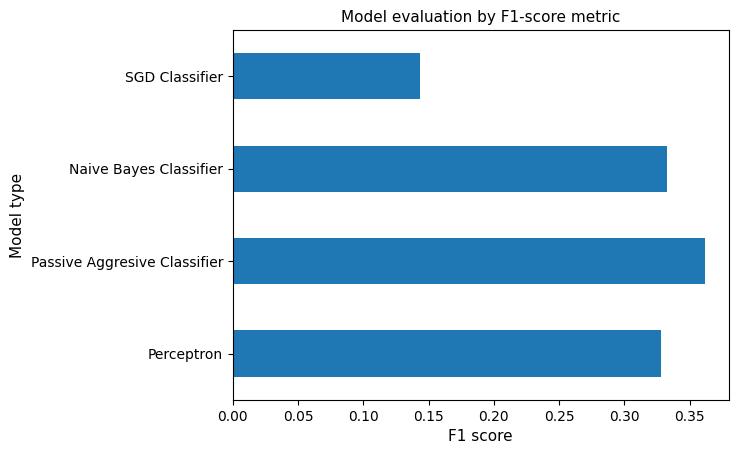

In [35]:
# Plot evaluation by f1_score

import matplotlib.pyplot as plt

eval_df['f1_score'].plot(kind="barh")
plt.title("Model evaluation by F1-score metric", fontsize=11)
plt.ylabel('Model type', fontsize=11)
plt.xlabel('F1 score', fontsize=11)

In [37]:
# Based on F1-score metrics, the best model is Passive Aggresive Classifier with macro average F1-score of 0.36

print(classification_report(y_pred=pa.predict(X_test), y_true=y_test, labels=new_classes))

              precision    recall  f1-score   support

      B-DATE       0.26      0.12      0.17        49
  B-LOCATION       0.55      0.21      0.30        78
       B-ORG       0.52      0.50      0.51       132
    B-PERSON       0.78      0.68      0.72       210
      I-DATE       0.29      0.13      0.18        60
  I-LOCATION       0.43      0.07      0.12        42
       I-ORG       0.47      0.47      0.47       110
    I-PERSON       0.63      0.31      0.42        87

   micro avg       0.58      0.42      0.49       768
   macro avg       0.49      0.31      0.36       768
weighted avg       0.56      0.42      0.46       768



**BERT**

In [7]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus

In [9]:
# Load train, validation, test word label datasets

train = pd.read_csv('data/ner/train.csv')
train

,message_id,text,entities,annotation
0,<11792830.1075859955495.JavaMail.evans@thyme>,Good catch. NY law should apply throughout th...,"[{'word': 'Leonardo Pacheco', 'tag': 'PERSON'}...","[('Leonardo Pacheco', 'PERSON'), ('NY', 'LOCAT..."
1,<16461482.1075846947944.JavaMail.evans@thyme>,"Tana,\nWow, you are really on the ball. Looks...","[{'word': 'Tana', 'tag': 'PERSON'}, {'word': '...","[('Tana', 'PERSON'), ('Matthias', 'PERSON'), (..."
2,<27347038.1075842439828.JavaMail.evans@thyme>,I am very pleased to announce that L.D. Stephe...,"[{'word': 'L.D. Stephens', 'tag': 'PERSON'}, {...","[('L.D. Stephens', 'PERSON'), ('Enron', 'PERSO..."
3,<22015863.1075844739388.JavaMail.evans@thyme>,"Chris:\n\nWe should chat. Per the ISDA, ENA i...","[{'word': 'Chris H Foster', 'tag': 'PERSON'}, ...","[('Chris H Foster', 'PERSON'), ('Sara Shacklet..."
4,<27358009.1075862249772.JavaMail.evans@thyme>,I have made additional changes on pages 11-12 ...,"[{'word': 'Mark Mayer', 'tag': 'PERSON'}, {'wo...","[('Mark Mayer', 'PERSON'), ('BPA', 'PERSON'), ..."
...,...,...,...,...
763,<23887193.1075840960293.JavaMail.evans@thyme>,We plan to have a conference call at 2pm Sunda...,"[{'word': 'David', 'tag': 'PERSON'}, {'word': ...","[('David', 'PERSON'), ('Tammie', 'PERSON'), ('..."
764,<12852426.1075844351646.JavaMail.evans@thyme>,Attached in WordPerfect are blacklines of the ...,"[{'word': 'Deborah Lowe', 'tag': 'PERSON'}, {'...","[('Deborah Lowe', 'PERSON'), ('1717 Main Stree..."
765,<685271.1075852754266.JavaMail.evans@thyme>,We intend to start officializing a gas book fo...,"[{'word': 'Kathy', 'tag': 'PERSON'}, {'word': ...","[('Kathy', 'PERSON'), ('McKay', 'PERSON'), ('J..."
766,<3384182.1075849303276.JavaMail.evans@thyme>,We are very close to sending out a redline.? A...,"[{'word': 'Linda Y. Sherif', 'tag': 'PERSON'},...","[('Linda Y. Sherif', 'PERSON'), ('120 Montgome..."


In [10]:
val = pd.read_csv('data/ner/val.csv')
val

,message_id,text,entities,annotation
0,<18050053.1075859962876.JavaMail.evans@thyme>,"Al:\n\nPer my voice mail, I have left a messag...","[{'word': 'Al', 'tag': 'PERSON'}, {'word': 'Ma...","[('Al', 'PERSON'), ('Mark', 'PERSON'), ('Alfre..."
1,<31623156.1075845089208.JavaMail.evans@thyme>,"To all,\n\nI visited with Kam earlier today to...","[{'word': 'Kam', 'tag': 'PERSON'}, {'word': 'P...","[('Kam', 'PERSON'), ('Pete', 'PERSON'), ('Scot..."
2,<24135778.1075846138474.JavaMail.evans@thyme>,"Beth, Mark - \n\nI think we are ready to move ...","[{'word': 'Beth', 'tag': 'PERSON'}, {'word': '...","[('Beth', 'PERSON'), ('Mark', 'PERSON'), ('Ste..."
3,<9457688.1075861461211.JavaMail.evans@thyme>,"Dear Jason Wolfe,\n\nWe are happy to inform yo...","[{'word': 'Jason Wolfe', 'tag': 'PERSON'}, {'w...","[('Jason Wolfe', 'PERSON'), ('Sergei', 'PERSON..."
4,<26484226.1075855280232.JavaMail.evans@thyme>,Scheduling Issue:\t\n\n\t1024\tMIRANT(Rala) to...,"[{'word': 'Rala', 'tag': 'PERSON'}, {'word': '...","[('Rala', 'PERSON'), ('Katherine', 'PERSON'), ..."
...,...,...,...,...
91,<10689485.1075851883019.JavaMail.evans@thyme>,"?\n?\n?\n?\n?\n?\n?\n?\nHi all, Merry Christma...","[{'word': 'Diane', 'tag': 'PERSON'}, {'word': ...","[('Diane', 'PERSON'), ('Christmas', 'DATE'), (..."
92,<12019737.1075861047362.JavaMail.evans@thyme>,"March 13, 2002\nNotice No. NMS-22\n\n\nNOTICE ...","[{'word': 'Michael Cokeley', 'tag': 'PERSON'},...","[('Michael Cokeley', 'PERSON'), ('David Kimmel..."
93,<31192798.1075842099616.JavaMail.evans@thyme>,Steve:\nI am faxing you our remaining comments...,"[{'word': 'Steve', 'tag': 'PERSON'}, {'word': ...","[('Steve', 'PERSON'), ('DB', 'PERSON'), ('Caro..."
94,<28609896.1075861988637.JavaMail.evans@thyme>,"Mark,\n\nI spoke to the postmaster and she sta...","[{'word': 'Mark', 'tag': 'PERSON'}, {'word': '...","[('Mark', 'PERSON'), ('Veronica', 'PERSON')]"


In [11]:
test = pd.read_csv('data/ner/test.csv')
test

,message_id,text,entities,annotation
0,<15886210.1075854965508.JavaMail.evans@thyme>,Allright fellas here's the gameplan . . . I'll...,"[{'word': 'Kevin A. Boone', 'tag': 'PERSON'}, ...","[('Kevin A. Boone', 'PERSON'), ('Matt', 'PERSO..."
1,<17217905.1075853978006.JavaMail.evans@thyme>,"Tina,\nKoch never returned my calls. Based on ...","[{'word': 'Tina', 'tag': 'PERSON'}, {'word': '...","[('Tina', 'PERSON'), ('Koch', 'PERSON'), ('Cyn..."
2,<28372483.1075843343800.JavaMail.evans@thyme>,I wanted to follow-up with everyone following ...,"[{'word': 'Steve M', 'tag': 'PERSON'}, {'word'...","[('Steve M', 'PERSON'), ('Janine', 'PERSON'), ..."
3,<7553175.1075863444700.JavaMail.evans@thyme>,"Vince,\n\n I agree with you that it's a lesso...","[{'word': 'Vince', 'tag': 'PERSON'}, {'word': ...","[('Vince', 'PERSON'), ('Frank', 'PERSON'), ('S..."
4,<16687289.1075862330552.JavaMail.evans@thyme>,I trust everything is going well. Please let ...,"[{'word': 'next Board meeting', 'tag': 'DATE'}...","[('next Board meeting', 'DATE'), ('2001', 'DAT..."
...,...,...,...,...
91,<17780105.1075840540168.JavaMail.evans@thyme>,"Heidi,\n\nI have no way of being able to discu...","[{'word': 'Heidi', 'tag': 'PERSON'}, {'word': ...","[('Heidi', 'PERSON'), ('Randall Chapman', 'PER..."
92,<16492427.1075847631885.JavaMail.evans@thyme>,Teh rest of the parts for Phil's PC arrived to...,"[{'word': 'Phil', 'tag': 'PERSON'}, {'word': '...","[('Phil', 'PERSON'), ('Kathy', 'PERSON'), ('Al..."
93,<11901989.1075844026014.JavaMail.evans@thyme>,Hey guys thanks a million for supporting the g...,"[{'word': 'Next Wednesday August 16th', 'tag':...","[('Next Wednesday August 16th', 'DATE'), ('41s..."
94,<17922592.1075839996237.JavaMail.evans@thyme>,"Keoni,\nI am not concerned with the improperly...","[{'word': 'Keoni', 'tag': 'PERSON'}, {'word': ...","[('Keoni', 'PERSON'), ('Bill', 'PERSON'), ('CA..."


In [12]:
from tqdm import tqdm
tqdm.pandas()
import ast

# Convert list as string to list
train['annotation'] = train['annotation'].progress_apply(lambda x: ast.literal_eval(x))
val['annotation'] = val['annotation'].progress_apply(lambda x: ast.literal_eval(x))
test['annotation'] = test['annotation'].progress_apply(lambda x: ast.literal_eval(x))

100%|██████████| 96/96 [00:00<00:00, 3612.11it/s]


In [13]:
from difflib import SequenceMatcher
import re
import pickle

def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)

    return match_list, string

def mark_sentence(s, match_list):
    '''
    Marks all the entities in the sentence as per the BIO scheme.
    '''
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'

    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def isFound(substr, string):
    if (string.find(substr) == -1):
        return False
    return True

def clean(text):
    """
    Helper fuction to add a space before the punctuations.
    This is for better tokenization.
    """
    filters = ["!", "#", "$", "%", "&", "(", ")", "/", "*", ".", ":", ";", "<", "=", ">", "?", "@", "[",
               "\\", "]", "_", "`", "{", "}", "~", "'", ","]
    for i in text:
        if i in filters:
            text = text.replace(i, " " + i)
    return text

def create_data(df):
    '''
    Function responsible for the creation of data
    '''
    data = []
    for text, annotation in zip(df.text, df.annotation):

        # Keep only entities that are found in text
        annotation = [
            entity for entity in annotation
                if isFound(entity[0], text)
        ]

        text = clean(text)
        text_ = text

        match_list = []
        for i in annotation:
            a, text_ = matcher(text, i[0])
            if a:
                match_list.append((a[0][0], a[0][1], i[1]))

        d = mark_sentence(text, match_list)
        data.append(d)

    return data

In [14]:
# Convert data to IOB format

train_ner_data = create_data(train)
val_ner_data = create_data(val)
test_ner_data = create_data(test)

In [15]:
%pprint
train_ner_data[0]

Pretty printing has been turned OFF


{'Good': 'O', 'catch': 'O', '.': 'O', 'NY': 'B-LOCATION', 'law': 'O', 'should': 'O', 'apply': 'O', 'throughout': 'O', 'the': 'O', 'Americas': 'B-LOCATION', 'and': 'O', 'in': 'O', 'Japan': 'B-LOCATION', 'We': 'O', 'used': 'O', 'UK': 'O', 'Europe': 'B-LOCATION', 'Singapore': 'B-LOCATION', 'on': 'O', 'theory': 'O', 'counterparties': 'O', 'there': 'O', 'would': 'O', 'be': 'O', 'more': 'O', 'comfortable': 'O', 'with': 'O', 'Uk': 'O', 'I': 'O', "'m": 'O', 'not': 'O', 'sure': 'O', 'which': 'O', 'Australians': 'O', 'prefer': 'O', 'What': 'O', 'do': 'O', 'you': 'O', 'think': 'O', 'of': 'O', 'following': 'O', ':': 'O', '16': 'O', 'If': 'O', 'are': 'O', 'accessing': 'O', 'this': 'O', 'website': 'O', 'from': 'O', 'North': 'B-LOCATION', 'America': 'I-LOCATION', ',': 'O', 'South': 'B-LOCATION', 'or': 'O', 'terms': 'O', 'legal': 'O', 'Privacy': 'O', 'statement': 'O', 'shall': 'O', 'governed': 'O', 'by': 'O', 'laws': 'O', 'State': 'O', 'New': 'O', 'York': 'O', ';': 'O', 'if': 'O', 'any': 'O', 'other':

In [16]:
val_ner_data[0]

{'Al': 'B-PERSON', ':': 'O', 'Per': 'O', 'my': 'O', 'voice': 'O', 'mail': 'O', ',': 'O', 'I': 'O', 'have': 'O', 'left': 'O', 'a': 'O', 'message': 'O', 'for': 'O', 'Mark': 'B-PERSON', 'to': 'O', 'give': 'O', 'his': 'O', 'input': 'O', '.': 'O', 'think': 'O', 'you': 'O', 'should': 'O', 'revise': 'O', 'the': 'O', 'letter': 'O', 'as': 'O', 'follows': 'O', 'subject': 'O', "'s": 'O', 'edits': 'O', '"Please': 'O', 'be': 'O', 'advised': 'O', 'that': 'O', 'effective': 'O', 'July': 'O', '17': 'O', '2000': 'O', 'MGplc': 'B-ORG', 'was': 'O', 'aquired': 'O', 'by': 'O', 'Enron': 'B-ORG', 'group': 'O', 'MG': 'B-ORG', 'London': 'I-ORG', 'Inc': 'I-ORG', 'part': 'O', 'of': 'O', 'Effective': 'O', 'October': 'O', '9': 'O', 'changed': 'O', 'its': 'O', 'name': 'O', '"Enron': 'O', 'Trading': 'O', 'Services': 'O', 'Inc"': 'O', 'Also': 'O', 'please': 'O', 'Financial': 'O', 'Status': 'O', '(now': 'O', ')': 'O', 'has': 'O', 'not': 'O', 'If': 'O', 'there': 'O', 'are': 'O', 'any': 'O', 'questions': 'O', 'call': 'O'

In [17]:
test_ner_data[0]

{'Allright': 'O', 'fellas': 'O', 'here': 'O', "'s": 'O', 'the': 'O', 'gameplan': 'O', '.': 'O', 'I': 'O', "'ll": 'O', 'drive': 'O', 'leave': 'O', 'at': 'O', '8am': 'O', 'tomorrow': 'O', 'morning': 'O', 'we': 'O', 'can': 'O', 'meet': 'O', 'my': 'O', 'house': 'O', 'or': 'O', 'Matt': 'B-PERSON', 'it': 'O', 'doesn': 'O', "'t": 'O', 'really': 'O', 'matter': 'O', 'to': 'O', 'me': 'O', 'plan': 'O', 'on': 'O', 'leaving': 'O', 'BR': 'O', 'no': 'O', 'later': 'O', 'than': 'O', '9am': 'O', 'sunday': 'O', 'morn': 'O', 'Geaux': 'O', 'Tigers': 'O', 'Regards': 'O', ',': 'O', 'Kevin': 'O', 'A': 'O', 'Boone': 'O', 'Accenture': 'B-ORG', 'Houston': 'O', 'Consultant': 'O', 'Energy': 'O', '(Octel': 'O', ')': 'O', '713': 'O', '.837': 'O', '.1638': 'O', '(Client': 'O', '281': 'O', '.848': 'O', '.1619': 'O', '(C': 'O', '.306': 'O', '.7940': 'O', '(H': 'O', '.864': 'O', '.4149': 'O', '.A': 'O', '.Boone': 'O', '@accenture': 'O', '.com': 'O', 'Our': 'O', 'web': 'O', 'address': 'O', 'is': 'O', 'http': 'O', ':': 'O

In [18]:
# Create utility function to write annotated text to .txt file format

def dump_to_txt_file(data, filepath):
    """
    Dump data to txt file

    :param data     : data to save
    :param filepath : output filepath name
    """
    with open(filepath, 'w') as f:
        for d in data:
            for i in d.keys():
                f.writelines(i + ' ' + d[i] +'\n')
            f.writelines('\n')

In [19]:
# We need to save train_ds, val_ds, and test_ds as txt file. This is the required format expected by flairNLP library.

dump_to_txt_file(train_ner_data, "data/ner/train_ner_data.txt")
dump_to_txt_file(val_ner_data, "data/ner/val_ner_data.txt")
dump_to_txt_file(test_ner_data, "data/ner/test_ner_data.txt")

In [8]:
# define columns

columns = {0: "text", 1: "ner"}

# this is the folder in which train, validation and test files reside
data_folder = "data/ner"

# init a corpus using column format, data folder and the names of the train, val, and test files
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file="train_ner_data.txt",
                              test_file="test_ner_data.txt",
                              dev_file="val_ner_data.txt")

2023-09-24 20:15:14,342 Reading data from data/ner
2023-09-24 20:15:14,344 Train: data/ner/train_ner_data.txt
2023-09-24 20:15:14,345 Dev: data/ner/val_ner_data.txt
2023-09-24 20:15:14,346 Test: data/ner/test_ner_data.txt


In [9]:
print(len(corpus.train))

768


In [10]:
corpus.train[0]

Sentence[76]: "Good catch . NY law should apply throughout the Americas and in Japan We used UK Europe Singapore on theory counterparties there would be more comfortable with Uk I 'm not sure which Australians prefer What do you think of following : 16 If are accessing this website from North America , South or terms legal Privacy statement shall governed by laws State New York ; if any other location its English Leonardo Pacheco @ENRON Australia" → ["NY"/LOCATION, "Americas"/LOCATION, "Japan"/LOCATION, "Europe"/LOCATION, "Singapore"/LOCATION, "North America"/LOCATION, "South"/LOCATION, "Leonardo Pacheco"/PERSON, "Australia"/LOCATION]

In [11]:
print(len(corpus.test))

96


In [12]:
corpus.test[0]

Sentence[109]: "Allright fellas here 's the gameplan . I 'll drive leave at 8am tomorrow morning we can meet my house or Matt it doesn 't really matter to me plan on leaving BR no later than 9am sunday morn Geaux Tigers Regards , Kevin A Boone Accenture Houston Consultant Energy (Octel ) 713 .837 .1638 (Client 281 .848 .1619 (C .306 .7940 (H .864 .4149 .A .Boone @accenture .com Our web address is http : / /www .accenture This message for designated recipient only and may contain privileged confidential information If you have received in error please notify sender immediately delete original Any other use of email by prohibited" → ["Matt"/PERSON, "Accenture"/ORG]

In [13]:
print(len(corpus.dev))

96


In [14]:
corpus.dev[0]

Sentence[82]: "Al : Per my voice mail , I have left a message for Mark to give his input . think you should revise the letter as follows subject 's edits "Please be advised that effective July 17 2000 MGplc was aquired by Enron group MG London Inc part of Effective October 9 changed its name "Enron Trading Services Inc" Also please Financial Status (now ) has not If there are any questions call me at 212 715 5845 ." Alfred Pennisi @MGUSA" → ["Al"/PERSON, "Mark"/PERSON, "MGplc"/ORG, "Enron"/ORG, "MG London Inc"/ORG, "Alfred Pennisi"/PERSON]

In [15]:
# make the label dictionary from the corpus

label_type = 'ner'
label_dict = corpus.make_label_dictionary(label_type=label_type, add_unk=False)
print(label_dict)

2023-09-24 20:15:23,527 Computing label dictionary. Progress:


768it [00:00, 31300.47it/s]

2023-09-24 20:15:23,562 Dictionary created for label 'ner' with 4 values: PERSON (seen 1625 times), ORG (seen 924 times), LOCATION (seen 464 times), DATE (seen 442 times)
Dictionary with 4 tags: PERSON, ORG, LOCATION, DATE


In [16]:
from flair.embeddings import TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
import torch

# Initialize fine-tuneable transformer embeddings WITH document context
# We'll use a verion of BERT namely 'bert-base-uncased'
embeddings = TransformerWordEmbeddings(model='bert-base-uncased',
                                       layers="-1",
                                       subtoken_pooling="first",
                                       fine_tune=True,
                                       use_context=True,
                                       )

tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type='ner',
                        tag_format='BIO',
                        use_crf=False,
                        use_rnn=False,
                        reproject_embeddings=False,
                        )

2023-09-24 20:15:31,866 SequenceTagger predicts: Dictionary with 9 tags: O, B-PERSON, I-PERSON, B-ORG, I-ORG, B-LOCATION, I-LOCATION, B-DATE, I-DATE


In [17]:
# Initialize trainer

trainer = ModelTrainer(tagger, corpus)
trainer

In [18]:
# Define function to determine the current date

from datetime import datetime

def get_current_date(date_format="%Y%m%d"):
    """ Get current time

    :param date_format: input date format
    :return: string date
    """
    now = datetime.now()
    current_time = now.strftime(f"{date_format}")
    return current_time

In [31]:
# The current date will serve as the model version number

model_version = get_current_date(date_format="%Y%m%d%H%M")
model_version

'202309241957'

In [32]:
LR = 5e-5
BATCH_SIZE = 16
NUM_EPOCHS = 5

trainer.fine_tune(f"models/taggers/ner/{model_version}",
              learning_rate=LR,
              mini_batch_size=BATCH_SIZE,
              max_epochs=NUM_EPOCHS,
              optimizer=torch.optim.AdamW,
              main_evaluation_metric=("micro avg", "f1-score")
              )

2023-09-24 19:57:20,101 ----------------------------------------------------------------------------------------------------
2023-09-24 19:57:20,112 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30523, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(

100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

2023-09-24 19:58:13,996 Evaluating as a multi-label problem: False
2023-09-24 19:58:14,023 DEV : loss 0.2221193164587021 - f1-score (micro avg)  0.2345
2023-09-24 19:58:14,036 ----------------------------------------------------------------------------------------------------


2023-09-24 19:58:19,557 epoch 2 - iter 4/48 - loss 0.22381216 - time (sec): 5.52 - samples/sec: 1145.54 - lr: 0.000044
2023-09-24 19:58:22,941 epoch 2 - iter 8/48 - loss 0.22171547 - time (sec): 8.90 - samples/sec: 1384.35 - lr: 0.000043
2023-09-24 19:58:26,869 epoch 2 - iter 12/48 - loss 0.21810096 - time (sec): 12.83 - samples/sec: 1427.16 - lr: 0.000042
2023-09-24 19:58:31,065 epoch 2 - iter 16/48 - loss 0.21696108 - time (sec): 17.02 - samples/sec: 1435.37 - lr: 0.000041
2023-09-24 19:58:36,613 epoch 2 - iter 20/48 - loss 0.21389038 - time (sec): 22.57 - samples/sec: 1353.18 - lr: 0.000040
2023-09-24 19:58:40,498 epoch 2 - iter 24/48 - loss 0.21148096 - time (sec): 26.46 - samples/sec: 1382.12 - lr: 0.000039
2023-09-24 19:58:44,182 epoch 2 - iter 28/48 - loss 0.21307722 - time (sec): 30.14 - samples/sec: 1410.77 - lr: 0.000038
2023-09-24 19:58:48,486 epoch 2 - iter 32/48 - loss 0.20685158 - time (sec): 34.45 - samples/sec: 1409.18 - lr: 0.000037
2023-09-24 19:58:51,998 epoch 2 - it

100%|██████████| 6/6 [00:04<00:00,  1.40it/s]

2023-09-24 19:59:09,044 Evaluating as a multi-label problem: False
2023-09-24 19:59:09,069 DEV : loss 0.1413034051656723 - f1-score (micro avg)  0.6184
2023-09-24 19:59:09,081 ----------------------------------------------------------------------------------------------------


2023-09-24 19:59:13,462 epoch 3 - iter 4/48 - loss 0.13167093 - time (sec): 4.38 - samples/sec: 1373.31 - lr: 0.000033
2023-09-24 19:59:17,438 epoch 3 - iter 8/48 - loss 0.14176730 - time (sec): 8.36 - samples/sec: 1439.25 - lr: 0.000032
2023-09-24 19:59:21,491 epoch 3 - iter 12/48 - loss 0.14270455 - time (sec): 12.41 - samples/sec: 1469.94 - lr: 0.000031
2023-09-24 19:59:26,195 epoch 3 - iter 16/48 - loss 0.14008014 - time (sec): 17.11 - samples/sec: 1411.57 - lr: 0.000030
2023-09-24 19:59:30,202 epoch 3 - iter 20/48 - loss 0.13761293 - time (sec): 21.12 - samples/sec: 1425.42 - lr: 0.000029
2023-09-24 19:59:34,570 epoch 3 - iter 24/48 - loss 0.14276203 - time (sec): 25.49 - samples/sec: 1427.09 - lr: 0.000028
2023-09-24 19:59:39,032 epoch 3 - iter 28/48 - loss 0.14102589 - time (sec): 29.95 - samples/sec: 1415.18 - lr: 0.000027
2023-09-24 19:59:43,819 epoch 3 - iter 32/48 - loss 0.13952291 - time (sec): 34.74 - samples/sec: 1401.58 - lr: 0.000026
2023-09-24 19:59:48,055 epoch 3 - it

100%|██████████| 6/6 [00:03<00:00,  1.83it/s]

2023-09-24 20:00:04,939 Evaluating as a multi-label problem: False
2023-09-24 20:00:04,955 DEV : loss 0.12771132588386536 - f1-score (micro avg)  0.6226
2023-09-24 20:00:04,963 ----------------------------------------------------------------------------------------------------


2023-09-24 20:00:09,790 epoch 4 - iter 4/48 - loss 0.11859390 - time (sec): 4.83 - samples/sec: 1279.75 - lr: 0.000022
2023-09-24 20:00:14,475 epoch 4 - iter 8/48 - loss 0.11040869 - time (sec): 9.51 - samples/sec: 1301.33 - lr: 0.000021
2023-09-24 20:00:18,754 epoch 4 - iter 12/48 - loss 0.11633330 - time (sec): 13.79 - samples/sec: 1331.16 - lr: 0.000020
2023-09-24 20:00:23,273 epoch 4 - iter 16/48 - loss 0.12161531 - time (sec): 18.31 - samples/sec: 1340.03 - lr: 0.000019
2023-09-24 20:00:27,322 epoch 4 - iter 20/48 - loss 0.12280147 - time (sec): 22.36 - samples/sec: 1379.69 - lr: 0.000018
2023-09-24 20:00:31,283 epoch 4 - iter 24/48 - loss 0.12028609 - time (sec): 26.32 - samples/sec: 1395.49 - lr: 0.000017
2023-09-24 20:00:35,604 epoch 4 - iter 28/48 - loss 0.11655327 - time (sec): 30.64 - samples/sec: 1402.66 - lr: 0.000016
2023-09-24 20:00:39,147 epoch 4 - iter 32/48 - loss 0.11664830 - time (sec): 34.18 - samples/sec: 1431.57 - lr: 0.000015
2023-09-24 20:00:44,263 epoch 4 - it

100%|██████████| 6/6 [00:03<00:00,  1.96it/s]

2023-09-24 20:01:00,483 Evaluating as a multi-label problem: False
2023-09-24 20:01:00,500 DEV : loss 0.1295626312494278 - f1-score (micro avg)  0.6123
2023-09-24 20:01:00,511 ----------------------------------------------------------------------------------------------------


2023-09-24 20:01:04,612 epoch 5 - iter 4/48 - loss 0.10074218 - time (sec): 4.10 - samples/sec: 1428.58 - lr: 0.000011
2023-09-24 20:01:08,402 epoch 5 - iter 8/48 - loss 0.09493009 - time (sec): 7.89 - samples/sec: 1542.30 - lr: 0.000010
2023-09-24 20:01:12,549 epoch 5 - iter 12/48 - loss 0.09336834 - time (sec): 12.04 - samples/sec: 1522.44 - lr: 0.000009
2023-09-24 20:01:17,808 epoch 5 - iter 16/48 - loss 0.09204279 - time (sec): 17.29 - samples/sec: 1412.57 - lr: 0.000008
2023-09-24 20:01:21,839 epoch 5 - iter 20/48 - loss 0.09590692 - time (sec): 21.33 - samples/sec: 1437.34 - lr: 0.000007
2023-09-24 20:01:26,606 epoch 5 - iter 24/48 - loss 0.09548017 - time (sec): 26.09 - samples/sec: 1407.30 - lr: 0.000006
2023-09-24 20:01:32,085 epoch 5 - iter 28/48 - loss 0.09449493 - time (sec): 31.57 - samples/sec: 1360.48 - lr: 0.000005
2023-09-24 20:01:36,386 epoch 5 - iter 32/48 - loss 0.09681371 - time (sec): 35.87 - samples/sec: 1368.41 - lr: 0.000005
2023-09-24 20:01:40,869 epoch 5 - it

100%|██████████| 6/6 [00:03<00:00,  1.99it/s]

2023-09-24 20:01:56,167 Evaluating as a multi-label problem: False
2023-09-24 20:01:56,189 DEV : loss 0.12764804065227509 - f1-score (micro avg)  0.626


2023-09-24 20:01:58,170 ----------------------------------------------------------------------------------------------------
2023-09-24 20:01:58,175 Testing using last state of model ...


100%|██████████| 6/6 [00:03<00:00,  1.92it/s]

2023-09-24 20:02:01,349 Evaluating as a multi-label problem: False
2023-09-24 20:02:01,372 0.5578	0.6268	0.5903	0.4384
2023-09-24 20:02:01,375 
Results:
- F-score (micro) 0.5903
- F-score (macro) 0.5209
- Accuracy 0.4384

By class:
              precision    recall  f1-score   support

      PERSON     0.7269    0.7811    0.7530       201
         ORG     0.4754    0.5839    0.5241       149
    LOCATION     0.5135    0.5135    0.5135        74
        DATE     0.2698    0.3208    0.2931        53

   micro avg     0.5578    0.6268    0.5903       477
   macro avg     0.4964    0.5498    0.5209       477
weighted avg     0.5644    0.6268    0.5932       477

2023-09-24 20:02:01,378 ----------------------------------------------------------------------------------------------------


{'test_score': 0.5903257650542941, 'dev_score_history': [0.2345058626465662, 0.618421052631579, 0.6225961538461537, 0.612330198537095, 0.6260330578512396], 'train_loss_history': [0.629298929330472, 0.20286607726690928, 0.14068687148249842, 0.11521556088726312, 0.09956445255606491], 'dev_loss_history': [0.2221193164587021, 0.1413034051656723, 0.12771132588386536, 0.1295626312494278, 0.12764804065227509]}

(0.0, 1.0)

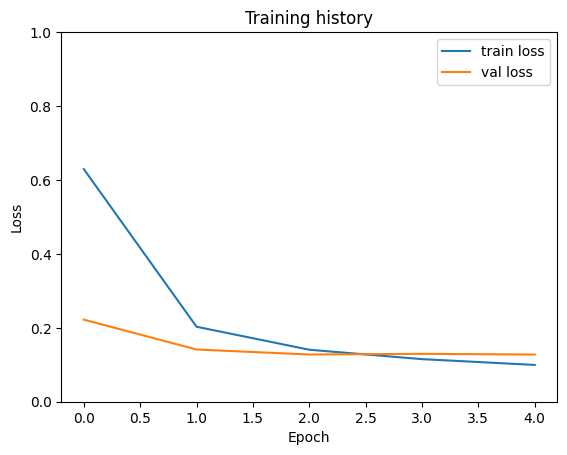

In [35]:
from collections import defaultdict
import matplotlib.pyplot as plt

history = defaultdict(list)
history['train_loss_history'] = [0.629298929330472, 0.20286607726690928, 0.14068687148249842, 0.11521556088726312, 0.09956445255606491]
history['dev_loss_history'] = [0.2221193164587021, 0.1413034051656723, 0.12771132588386536, 0.1295626312494278, 0.12764804065227509]

plt.figure()
plt.plot(history['train_loss_history'], label='train loss')
plt.plot(history['dev_loss_history'], label='val loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [37]:
sentences = corpus.test
sentences

In [38]:
# load tagger
tagger: SequenceTagger = SequenceTagger.load('models/taggers/ner/202309241957/final-model.pt')

2023-09-24 20:10:48,169 SequenceTagger predicts: Dictionary with 9 tags: O, B-PERSON, I-PERSON, B-ORG, I-ORG, B-LOCATION, I-LOCATION, B-DATE, I-DATE


In [40]:
def get_test_labels(sentences):
    """
    Get test labels
    """
    test_labels = []
    for sentence in sentences:
        sentence_labels = ["O"] * len(sentence)
        for label in sentence.get_labels('ner'):
            span = label.data_point
            if len(span) == 1:
                sentence_labels[span[0].idx - 1] = "B-" + label.value
            else:
                sentence_labels[span[0].idx - 1] = "B-" + label.value
                sentence_labels[span[-1].idx - 1] = "I-" + label.value
                for i in range(span[0].idx, span[-1].idx - 1):
                    sentence_labels[i] = "I-" + label.value

        test_labels.append(sentence_labels)
    return test_labels

def get_pred_labels(sentences, tagger):
    """
    Get predicted labels
    """
    tagger.predict(sentences, mini_batch_size=32, verbose=True,  embedding_storage_mode="none")

    pred_labels = []
    for sentence in sentences:
        sentence_labels = ["O"] * len(sentence)
        for label in sentence.get_labels('ner'):
            span = label.data_point
            if len(span) == 1:
                sentence_labels[span[0].idx - 1] = "B-" + label.value
            else:
                sentence_labels[span[0].idx - 1] = "B-" + label.value
                sentence_labels[span[-1].idx - 1] = "I-" + label.value
                for i in range(span[0].idx, span[-1].idx - 1):
                    sentence_labels[i] = "I-" + label.value

        pred_labels.append(sentence_labels)
    return pred_labels

In [43]:
%pprint
test_labels = get_test_labels(sentences)
test_labels[:3]

Pretty printing has been turned OFF


[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-PERSON', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-PERSON', 'B-ORG', 'I-ORG', 'O', 'O'], ['O', 'O',

In [44]:
pred_labels = get_pred_labels(sentences, tagger)
pred_labels[:3]

Batch inference: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


[['B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'B-PERSON', 'B-ORG', 'O', 'O', 'B-PERSON', 'O', 'O', 'B-ORG', 'B-LOCATION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-PERSON', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-

In [45]:
len(test_labels), len(pred_labels)

(96, 96)

In [46]:
import numpy

_test_labels = numpy.concatenate([numpy.array(i) for i in test_labels])
_test_labels

array(['O', 'O', 'O', ..., 'O', 'O', 'B-PERSON'], dtype='<U10')

In [47]:
_pred_labels = numpy.concatenate([numpy.array(i) for i in pred_labels])
_pred_labels

array(['B-PERSON', 'O', 'O', ..., 'O', 'O', 'B-PERSON'], dtype='<U10')

In [48]:
from sklearn.metrics import classification_report

labels = ['B-DATE', 'B-LOCATION', 'B-ORG', 'B-PERSON', 'I-DATE', 'I-LOCATION', 'I-ORG', 'I-PERSON']
print(classification_report(_test_labels, _pred_labels, labels=labels))

              precision    recall  f1-score   support

      B-DATE       0.33      0.40      0.36        53
  B-LOCATION       0.57      0.57      0.57        74
       B-ORG       0.55      0.67      0.60       149
    B-PERSON       0.78      0.84      0.81       201
      I-DATE       0.57      0.28      0.38        46
  I-LOCATION       0.50      0.30      0.37        30
       I-ORG       0.54      0.61      0.58        70
    I-PERSON       0.80      0.84      0.82        68

   micro avg       0.62      0.66      0.64       691
   macro avg       0.58      0.56      0.56       691
weighted avg       0.62      0.66      0.63       691



In [19]:
# The current date will serve as the model version number

model_version = get_current_date(date_format="%Y%m%d%H%M")
model_version

'202309242015'

In [20]:
LR = 5e-5
BATCH_SIZE = 16
NUM_EPOCHS = 10

trainer.fine_tune(f"models/taggers/ner/{model_version}",
              learning_rate=LR,
              mini_batch_size=BATCH_SIZE,
              max_epochs=NUM_EPOCHS,
              optimizer=torch.optim.AdamW,
              main_evaluation_metric=("micro avg", "f1-score")
              )

2023-09-24 20:16:35,103 ----------------------------------------------------------------------------------------------------
2023-09-24 20:16:35,108 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30523, 768)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(

100%|██████████| 6/6 [00:03<00:00,  1.51it/s]

2023-09-24 20:17:28,943 Evaluating as a multi-label problem: False
2023-09-24 20:17:28,976 DEV : loss 0.250569224357605 - f1-score (micro avg)  0.2935
2023-09-24 20:17:28,990 ----------------------------------------------------------------------------------------------------


2023-09-24 20:17:32,857 epoch 2 - iter 4/48 - loss 0.27881660 - time (sec): 3.86 - samples/sec: 1598.40 - lr: 0.000050
2023-09-24 20:17:37,071 epoch 2 - iter 8/48 - loss 0.26397586 - time (sec): 8.08 - samples/sec: 1510.91 - lr: 0.000049
2023-09-24 20:17:41,446 epoch 2 - iter 12/48 - loss 0.26867236 - time (sec): 12.45 - samples/sec: 1457.11 - lr: 0.000049
2023-09-24 20:17:45,218 epoch 2 - iter 16/48 - loss 0.25900080 - time (sec): 16.22 - samples/sec: 1488.02 - lr: 0.000048
2023-09-24 20:17:49,570 epoch 2 - iter 20/48 - loss 0.24929739 - time (sec): 20.58 - samples/sec: 1477.13 - lr: 0.000048
2023-09-24 20:17:54,814 epoch 2 - iter 24/48 - loss 0.24138383 - time (sec): 25.82 - samples/sec: 1418.03 - lr: 0.000047
2023-09-24 20:17:59,731 epoch 2 - iter 28/48 - loss 0.23666154 - time (sec): 30.74 - samples/sec: 1384.70 - lr: 0.000047
2023-09-24 20:18:04,096 epoch 2 - iter 32/48 - loss 0.23405549 - time (sec): 35.10 - samples/sec: 1381.46 - lr: 0.000046
2023-09-24 20:18:09,022 epoch 2 - it

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

2023-09-24 20:18:30,279 Evaluating as a multi-label problem: False
2023-09-24 20:18:30,315 DEV : loss 0.15357275307178497 - f1-score (micro avg)  0.5639
2023-09-24 20:18:30,333 ----------------------------------------------------------------------------------------------------


2023-09-24 20:18:34,205 epoch 3 - iter 4/48 - loss 0.18280439 - time (sec): 3.87 - samples/sec: 1595.68 - lr: 0.000044
2023-09-24 20:18:38,066 epoch 3 - iter 8/48 - loss 0.17321362 - time (sec): 7.73 - samples/sec: 1577.19 - lr: 0.000044
2023-09-24 20:18:42,448 epoch 3 - iter 12/48 - loss 0.16478259 - time (sec): 12.11 - samples/sec: 1508.75 - lr: 0.000043
2023-09-24 20:18:46,998 epoch 3 - iter 16/48 - loss 0.15777427 - time (sec): 16.66 - samples/sec: 1464.70 - lr: 0.000043
2023-09-24 20:18:51,407 epoch 3 - iter 20/48 - loss 0.15594970 - time (sec): 21.07 - samples/sec: 1436.57 - lr: 0.000042
2023-09-24 20:18:55,700 epoch 3 - iter 24/48 - loss 0.15550636 - time (sec): 25.36 - samples/sec: 1436.75 - lr: 0.000042
2023-09-24 20:19:01,429 epoch 3 - iter 28/48 - loss 0.15392499 - time (sec): 31.09 - samples/sec: 1367.83 - lr: 0.000041
2023-09-24 20:19:06,341 epoch 3 - iter 32/48 - loss 0.15398648 - time (sec): 36.01 - samples/sec: 1348.64 - lr: 0.000041
2023-09-24 20:19:10,639 epoch 3 - it

100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

2023-09-24 20:19:28,197 Evaluating as a multi-label problem: False
2023-09-24 20:19:28,224 DEV : loss 0.13580676913261414 - f1-score (micro avg)  0.5925
2023-09-24 20:19:28,238 ----------------------------------------------------------------------------------------------------


2023-09-24 20:19:33,192 epoch 4 - iter 4/48 - loss 0.11812275 - time (sec): 4.95 - samples/sec: 1232.67 - lr: 0.000039
2023-09-24 20:19:37,753 epoch 4 - iter 8/48 - loss 0.12271959 - time (sec): 9.51 - samples/sec: 1288.00 - lr: 0.000038
2023-09-24 20:19:41,338 epoch 4 - iter 12/48 - loss 0.12172099 - time (sec): 13.09 - samples/sec: 1410.40 - lr: 0.000038
2023-09-24 20:19:45,372 epoch 4 - iter 16/48 - loss 0.11917413 - time (sec): 17.13 - samples/sec: 1436.74 - lr: 0.000037
2023-09-24 20:19:50,289 epoch 4 - iter 20/48 - loss 0.12001025 - time (sec): 22.05 - samples/sec: 1397.51 - lr: 0.000037
2023-09-24 20:19:54,738 epoch 4 - iter 24/48 - loss 0.11968905 - time (sec): 26.49 - samples/sec: 1393.58 - lr: 0.000036
2023-09-24 20:19:59,469 epoch 4 - iter 28/48 - loss 0.11519499 - time (sec): 31.23 - samples/sec: 1370.47 - lr: 0.000036
2023-09-24 20:20:03,552 epoch 4 - iter 32/48 - loss 0.11330544 - time (sec): 35.31 - samples/sec: 1383.74 - lr: 0.000035
2023-09-24 20:20:07,666 epoch 4 - it

100%|██████████| 6/6 [00:03<00:00,  1.58it/s]

2023-09-24 20:20:24,691 Evaluating as a multi-label problem: False
2023-09-24 20:20:24,714 DEV : loss 0.13611148297786713 - f1-score (micro avg)  0.5987
2023-09-24 20:20:24,729 ----------------------------------------------------------------------------------------------------


2023-09-24 20:20:28,726 epoch 5 - iter 4/48 - loss 0.08270656 - time (sec): 3.99 - samples/sec: 1518.65 - lr: 0.000033
2023-09-24 20:20:32,386 epoch 5 - iter 8/48 - loss 0.08480999 - time (sec): 7.65 - samples/sec: 1595.20 - lr: 0.000033
2023-09-24 20:20:36,306 epoch 5 - iter 12/48 - loss 0.08386787 - time (sec): 11.57 - samples/sec: 1596.88 - lr: 0.000032
2023-09-24 20:20:40,704 epoch 5 - iter 16/48 - loss 0.08961045 - time (sec): 15.97 - samples/sec: 1540.24 - lr: 0.000032
2023-09-24 20:20:45,851 epoch 5 - iter 20/48 - loss 0.08965993 - time (sec): 21.12 - samples/sec: 1458.89 - lr: 0.000031
2023-09-24 20:20:50,449 epoch 5 - iter 24/48 - loss 0.08840117 - time (sec): 25.72 - samples/sec: 1443.27 - lr: 0.000031
2023-09-24 20:20:54,692 epoch 5 - iter 28/48 - loss 0.08709687 - time (sec): 29.96 - samples/sec: 1436.77 - lr: 0.000030
2023-09-24 20:20:59,967 epoch 5 - iter 32/48 - loss 0.08672790 - time (sec): 35.23 - samples/sec: 1393.03 - lr: 0.000030
2023-09-24 20:21:03,603 epoch 5 - it

100%|██████████| 6/6 [00:03<00:00,  1.54it/s]

2023-09-24 20:21:20,198 Evaluating as a multi-label problem: False
2023-09-24 20:21:20,222 DEV : loss 0.13003411889076233 - f1-score (micro avg)  0.6258
2023-09-24 20:21:20,235 ----------------------------------------------------------------------------------------------------


2023-09-24 20:21:24,152 epoch 6 - iter 4/48 - loss 0.04858793 - time (sec): 3.92 - samples/sec: 1542.19 - lr: 0.000028
2023-09-24 20:21:28,239 epoch 6 - iter 8/48 - loss 0.06353514 - time (sec): 8.00 - samples/sec: 1536.31 - lr: 0.000027
2023-09-24 20:21:31,927 epoch 6 - iter 12/48 - loss 0.06635338 - time (sec): 11.69 - samples/sec: 1558.54 - lr: 0.000027
2023-09-24 20:21:36,300 epoch 6 - iter 16/48 - loss 0.06708908 - time (sec): 16.06 - samples/sec: 1513.63 - lr: 0.000026
2023-09-24 20:21:40,314 epoch 6 - iter 20/48 - loss 0.06855053 - time (sec): 20.08 - samples/sec: 1518.07 - lr: 0.000026
2023-09-24 20:21:44,503 epoch 6 - iter 24/48 - loss 0.06803013 - time (sec): 24.27 - samples/sec: 1506.13 - lr: 0.000026
2023-09-24 20:21:49,539 epoch 6 - iter 28/48 - loss 0.06885310 - time (sec): 29.30 - samples/sec: 1458.41 - lr: 0.000025
2023-09-24 20:21:54,249 epoch 6 - iter 32/48 - loss 0.06999568 - time (sec): 34.01 - samples/sec: 1433.71 - lr: 0.000025
2023-09-24 20:21:58,851 epoch 6 - it

100%|██████████| 6/6 [00:03<00:00,  1.66it/s]

2023-09-24 20:22:14,351 Evaluating as a multi-label problem: False
2023-09-24 20:22:14,367 DEV : loss 0.1369745284318924 - f1-score (micro avg)  0.6306
2023-09-24 20:22:14,376 ----------------------------------------------------------------------------------------------------


2023-09-24 20:22:18,608 epoch 7 - iter 4/48 - loss 0.05347093 - time (sec): 4.23 - samples/sec: 1387.24 - lr: 0.000022
2023-09-24 20:22:22,713 epoch 7 - iter 8/48 - loss 0.05825195 - time (sec): 8.33 - samples/sec: 1418.62 - lr: 0.000022
2023-09-24 20:22:26,992 epoch 7 - iter 12/48 - loss 0.05394096 - time (sec): 12.61 - samples/sec: 1427.61 - lr: 0.000021
2023-09-24 20:22:31,953 epoch 7 - iter 16/48 - loss 0.05703863 - time (sec): 17.57 - samples/sec: 1371.94 - lr: 0.000021
2023-09-24 20:22:35,831 epoch 7 - iter 20/48 - loss 0.05643927 - time (sec): 21.45 - samples/sec: 1407.79 - lr: 0.000021
2023-09-24 20:22:40,387 epoch 7 - iter 24/48 - loss 0.05576627 - time (sec): 26.01 - samples/sec: 1397.17 - lr: 0.000020
2023-09-24 20:22:44,433 epoch 7 - iter 28/48 - loss 0.05973428 - time (sec): 30.05 - samples/sec: 1413.06 - lr: 0.000020
2023-09-24 20:22:49,869 epoch 7 - iter 32/48 - loss 0.05849898 - time (sec): 35.49 - samples/sec: 1368.43 - lr: 0.000019
2023-09-24 20:22:53,960 epoch 7 - it

100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

2023-09-24 20:23:10,217 Evaluating as a multi-label problem: False
2023-09-24 20:23:10,234 DEV : loss 0.1462002843618393 - f1-score (micro avg)  0.6291
2023-09-24 20:23:10,243 ----------------------------------------------------------------------------------------------------


2023-09-24 20:23:14,188 epoch 8 - iter 4/48 - loss 0.04757033 - time (sec): 3.94 - samples/sec: 1508.07 - lr: 0.000017
2023-09-24 20:23:18,225 epoch 8 - iter 8/48 - loss 0.04481067 - time (sec): 7.98 - samples/sec: 1494.62 - lr: 0.000016
2023-09-24 20:23:22,333 epoch 8 - iter 12/48 - loss 0.04508964 - time (sec): 12.09 - samples/sec: 1497.54 - lr: 0.000016
2023-09-24 20:23:25,877 epoch 8 - iter 16/48 - loss 0.04629205 - time (sec): 15.63 - samples/sec: 1546.78 - lr: 0.000016
2023-09-24 20:23:30,257 epoch 8 - iter 20/48 - loss 0.04985846 - time (sec): 20.01 - samples/sec: 1517.01 - lr: 0.000015
2023-09-24 20:23:34,167 epoch 8 - iter 24/48 - loss 0.04881717 - time (sec): 23.92 - samples/sec: 1526.45 - lr: 0.000015
2023-09-24 20:23:38,762 epoch 8 - iter 28/48 - loss 0.04843294 - time (sec): 28.51 - samples/sec: 1491.15 - lr: 0.000014
2023-09-24 20:23:44,156 epoch 8 - iter 32/48 - loss 0.04763228 - time (sec): 33.91 - samples/sec: 1437.08 - lr: 0.000014
2023-09-24 20:23:47,883 epoch 8 - it

100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

2023-09-24 20:24:04,368 Evaluating as a multi-label problem: False
2023-09-24 20:24:04,384 DEV : loss 0.14900630712509155 - f1-score (micro avg)  0.652
2023-09-24 20:24:04,393 ----------------------------------------------------------------------------------------------------


2023-09-24 20:24:09,323 epoch 9 - iter 4/48 - loss 0.04270381 - time (sec): 4.93 - samples/sec: 1244.67 - lr: 0.000011
2023-09-24 20:24:13,881 epoch 9 - iter 8/48 - loss 0.04009955 - time (sec): 9.48 - samples/sec: 1278.54 - lr: 0.000011
2023-09-24 20:24:18,484 epoch 9 - iter 12/48 - loss 0.03905215 - time (sec): 14.09 - samples/sec: 1297.24 - lr: 0.000011
2023-09-24 20:24:22,425 epoch 9 - iter 16/48 - loss 0.04150960 - time (sec): 18.03 - samples/sec: 1347.26 - lr: 0.000010
2023-09-24 20:24:26,810 epoch 9 - iter 20/48 - loss 0.04122218 - time (sec): 22.41 - samples/sec: 1355.97 - lr: 0.000010
2023-09-24 20:24:31,461 epoch 9 - iter 24/48 - loss 0.04038085 - time (sec): 27.06 - samples/sec: 1345.98 - lr: 0.000009
2023-09-24 20:24:34,938 epoch 9 - iter 28/48 - loss 0.04122336 - time (sec): 30.54 - samples/sec: 1387.77 - lr: 0.000009
2023-09-24 20:24:39,178 epoch 9 - iter 32/48 - loss 0.03934472 - time (sec): 34.78 - samples/sec: 1387.98 - lr: 0.000008
2023-09-24 20:24:43,613 epoch 9 - it

100%|██████████| 6/6 [00:03<00:00,  1.75it/s]

2023-09-24 20:24:59,196 Evaluating as a multi-label problem: False
2023-09-24 20:24:59,215 DEV : loss 0.15591107308864594 - f1-score (micro avg)  0.6363
2023-09-24 20:24:59,225 ----------------------------------------------------------------------------------------------------


2023-09-24 20:25:03,814 epoch 10 - iter 4/48 - loss 0.03614801 - time (sec): 4.58 - samples/sec: 1319.20 - lr: 0.000006
2023-09-24 20:25:08,096 epoch 10 - iter 8/48 - loss 0.03623441 - time (sec): 8.87 - samples/sec: 1385.53 - lr: 0.000006
2023-09-24 20:25:12,423 epoch 10 - iter 12/48 - loss 0.03396727 - time (sec): 13.19 - samples/sec: 1385.83 - lr: 0.000005
2023-09-24 20:25:16,608 epoch 10 - iter 16/48 - loss 0.03459130 - time (sec): 17.38 - samples/sec: 1392.48 - lr: 0.000005
2023-09-24 20:25:21,247 epoch 10 - iter 20/48 - loss 0.03434782 - time (sec): 22.02 - samples/sec: 1375.15 - lr: 0.000004
2023-09-24 20:25:25,645 epoch 10 - iter 24/48 - loss 0.03273576 - time (sec): 26.42 - samples/sec: 1378.82 - lr: 0.000004
2023-09-24 20:25:29,325 epoch 10 - iter 28/48 - loss 0.03367364 - time (sec): 30.10 - samples/sec: 1405.09 - lr: 0.000003
2023-09-24 20:25:34,050 epoch 10 - iter 32/48 - loss 0.03310148 - time (sec): 34.82 - samples/sec: 1394.11 - lr: 0.000003
2023-09-24 20:25:38,945 epoc

100%|██████████| 6/6 [00:04<00:00,  1.49it/s]

2023-09-24 20:25:55,550 Evaluating as a multi-label problem: False
2023-09-24 20:25:55,578 DEV : loss 0.16027101874351501 - f1-score (micro avg)  0.6339


2023-09-24 20:25:57,481 ----------------------------------------------------------------------------------------------------
2023-09-24 20:25:57,489 Testing using last state of model ...


100%|██████████| 6/6 [00:02<00:00,  2.04it/s]

2023-09-24 20:26:00,455 Evaluating as a multi-label problem: False
2023-09-24 20:26:00,476 0.5747	0.6373	0.6044	0.4517
2023-09-24 20:26:00,477 
Results:
- F-score (micro) 0.6044
- F-score (macro) 0.5433
- Accuracy 0.4517

By class:
              precision    recall  f1-score   support

      PERSON     0.7569    0.8209    0.7876       201
         ORG     0.4713    0.4966    0.4837       149
    LOCATION     0.5500    0.5946    0.5714        74
        DATE     0.2838    0.3962    0.3307        53

   micro avg     0.5747    0.6373    0.6044       477
   macro avg     0.5155    0.5771    0.5433       477
weighted avg     0.5830    0.6373    0.6084       477

2023-09-24 20:26:00,482 ----------------------------------------------------------------------------------------------------


{'test_score': 0.6043737574552683,
 'dev_score_history': [0.29352780309936183,
  0.5638998682476944,
  0.5924967658473479,
  0.5986696230598669,
  0.62582056892779,
  0.6306098964326813,
  0.6290672451193058,
  0.6519823788546256,
  0.6362694300518135,
  0.6339381003201707],
 'train_loss_history': [0.8916702703664834,
  0.21932473314395443,
  0.1523036105050467,
  0.11594639986489899,
  0.08728030946450224,
  0.07104766294677414,
  0.05734593832593048,
  0.04859454562302461,
  0.03968363003981193,
  0.035281722130948816],
 'dev_loss_history': [0.250569224357605,
  0.15357275307178497,
  0.13580676913261414,
  0.13611148297786713,
  0.13003411889076233,
  0.1369745284318924,
  0.1462002843618393,
  0.14900630712509155,
  0.15591107308864594,
  0.16027101874351501]}

(0.0, 1.0)

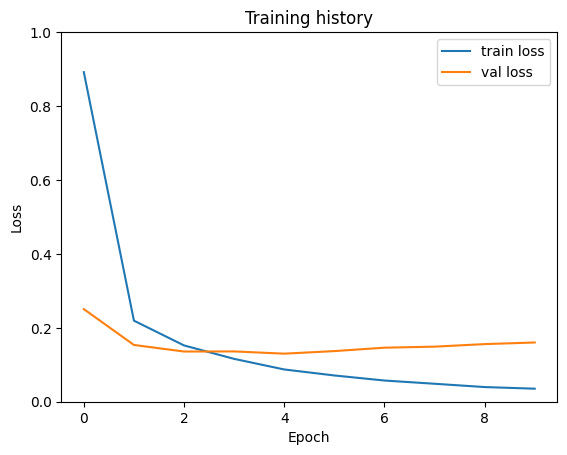

In [21]:
history = defaultdict(list)
history['train_loss_history'] = [
    0.8916702703664834,
    0.21932473314395443,
    0.1523036105050467,
    0.11594639986489899,
    0.08728030946450224,
    0.07104766294677414,
    0.05734593832593048,
    0.04859454562302461,
    0.03968363003981193,
    0.035281722130948816
]
history['dev_loss_history'] = [
    0.250569224357605,
    0.15357275307178497,
    0.13580676913261414,
    0.13611148297786713,
    0.13003411889076233,
    0.1369745284318924,
    0.1462002843618393,
    0.14900630712509155,
    0.15591107308864594,
    0.16027101874351501
  ]

plt.figure()
plt.plot(history['train_loss_history'], label='train loss')
plt.plot(history['dev_loss_history'], label='val loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [22]:
sentences = corpus.test
sentences

In [23]:
# load tagger
tagger: SequenceTagger = SequenceTagger.load('models/taggers/ner/202309242015/final-model.pt')

2023-09-24 20:30:10,786 SequenceTagger predicts: Dictionary with 9 tags: O, B-PERSON, I-PERSON, B-ORG, I-ORG, B-LOCATION, I-LOCATION, B-DATE, I-DATE


In [25]:
test_labels = get_test_labels(sentences)
test_labels[:3]

Pretty printing has been turned OFF


[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-PERSON', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'B-PERSON', 'B-ORG', 'I-ORG', 'O', 'O'], ['O', 'O',

In [26]:
pred_labels = get_pred_labels(sentences, tagger)
pred_labels[:3]

Batch inference: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


[['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-DATE', 'O', 'B-PERSON', 'O', 'O', 'O', 'B-PERSON', 'O', 'O', 'B-ORG', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['B-PERSON', 'O', 'B-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PERSON', 'O', 'B-

In [27]:
_test_labels = numpy.concatenate([numpy.array(i) for i in test_labels])
_test_labels

array(['O', 'O', 'O', ..., 'O', 'O', 'B-PERSON'], dtype='<U10')

In [28]:
_pred_labels = numpy.concatenate([numpy.array(i) for i in pred_labels])
_pred_labels

array(['B-PERSON', 'I-PERSON', 'O', ..., 'O', 'O', 'B-PERSON'],
      dtype='<U10')

In [29]:
labels = ['B-DATE', 'B-LOCATION', 'B-ORG', 'B-PERSON', 'I-DATE', 'I-LOCATION', 'I-ORG', 'I-PERSON']
print(classification_report(_test_labels, _pred_labels, labels=labels))

              precision    recall  f1-score   support

      B-DATE       0.31      0.43      0.36        53
  B-LOCATION       0.59      0.64      0.61        74
       B-ORG       0.57      0.60      0.59       149
    B-PERSON       0.77      0.84      0.80       201
      I-DATE       0.46      0.39      0.42        46
  I-LOCATION       0.62      0.60      0.61        30
       I-ORG       0.48      0.54      0.51        70
    I-PERSON       0.88      0.85      0.87        68

   micro avg       0.62      0.67      0.64       691
   macro avg       0.59      0.61      0.60       691
weighted avg       0.63      0.67      0.64       691



**Model Prediction**

In [30]:
# load the trained model with best F1-score

model = SequenceTagger.load('models/taggers/ner/202309242015/final-model.pt')

2023-09-24 20:33:33,831 SequenceTagger predicts: Dictionary with 9 tags: O, B-PERSON, I-PERSON, B-ORG, I-ORG, B-LOCATION, I-LOCATION, B-DATE, I-DATE


In [59]:
from flair.data import Sentence

def predict(text):
    """
    Function to predict entities
    """
    sentence = Sentence(text)

    # predict tags and print
    model.predict(sentence)

    entities = []
    for label in sentence.get_labels():
        entity = dict()
        entity["word"] = label.data_point.text
        entity["label"] = label.value
        entity["confidence"] = float("{0:.5f}".format(label.score))
        entities.append(entity)

    return entities

In [60]:
# Check sample test emails

test = pd.read_csv('data/ner/test.csv')
test

,message_id,text,entities,annotation
0,<15886210.1075854965508.JavaMail.evans@thyme>,Allright fellas here's the gameplan . . . I'll...,"[{'word': 'Kevin A. Boone', 'tag': 'PERSON'}, ...","[('Kevin A. Boone', 'PERSON'), ('Matt', 'PERSO..."
1,<17217905.1075853978006.JavaMail.evans@thyme>,"Tina,\nKoch never returned my calls. Based on ...","[{'word': 'Tina', 'tag': 'PERSON'}, {'word': '...","[('Tina', 'PERSON'), ('Koch', 'PERSON'), ('Cyn..."
2,<28372483.1075843343800.JavaMail.evans@thyme>,I wanted to follow-up with everyone following ...,"[{'word': 'Steve M', 'tag': 'PERSON'}, {'word'...","[('Steve M', 'PERSON'), ('Janine', 'PERSON'), ..."
3,<7553175.1075863444700.JavaMail.evans@thyme>,"Vince,\n\n I agree with you that it's a lesso...","[{'word': 'Vince', 'tag': 'PERSON'}, {'word': ...","[('Vince', 'PERSON'), ('Frank', 'PERSON'), ('S..."
4,<16687289.1075862330552.JavaMail.evans@thyme>,I trust everything is going well. Please let ...,"[{'word': 'next Board meeting', 'tag': 'DATE'}...","[('next Board meeting', 'DATE'), ('2001', 'DAT..."
...,...,...,...,...
91,<17780105.1075840540168.JavaMail.evans@thyme>,"Heidi,\n\nI have no way of being able to discu...","[{'word': 'Heidi', 'tag': 'PERSON'}, {'word': ...","[('Heidi', 'PERSON'), ('Randall Chapman', 'PER..."
92,<16492427.1075847631885.JavaMail.evans@thyme>,Teh rest of the parts for Phil's PC arrived to...,"[{'word': 'Phil', 'tag': 'PERSON'}, {'word': '...","[('Phil', 'PERSON'), ('Kathy', 'PERSON'), ('Al..."
93,<11901989.1075844026014.JavaMail.evans@thyme>,Hey guys thanks a million for supporting the g...,"[{'word': 'Next Wednesday August 16th', 'tag':...","[('Next Wednesday August 16th', 'DATE'), ('41s..."
94,<17922592.1075839996237.JavaMail.evans@thyme>,"Keoni,\nI am not concerned with the improperly...","[{'word': 'Keoni', 'tag': 'PERSON'}, {'word': ...","[('Keoni', 'PERSON'), ('Bill', 'PERSON'), ('CA..."


In [61]:
sample_email = test['text'].iloc[0]
print(sample_email)

Allright fellas here's the gameplan . . . I'll drive . . . leave at 8am
tomorrow morning . . . we can meet at my house or at Matt's it doesn't
really matter to me . . . plan on leaving BR no later than 9am sunday morn
. . . Geaux Tigers

Regards,

Kevin A. Boone
Accenture  Houston
Consultant  Energy
(Octel) 713.837.1638
(Client) 281.848.1619
(C) 713.306.7940
(H) 713.864.4149
Kevin.A.Boone@accenture.com

Our web address is http://www.accenture.com


This message is for the designated recipient only and may contain
privileged or confidential information.  If you have received it in error,
please notify the sender immediately and delete the original.  Any other
use of the email by you is prohibited.


In [62]:
%pprint
predict(sample_email)

[{'word': 'tomorrow morning', 'label': 'DATE', 'confidence': 0.8091},
 {'word': 'Matt', 'label': 'PERSON', 'confidence': 0.98989},
 {'word': 'Accenture', 'label': 'ORG', 'confidence': 0.979},
 {'word': 'Houston', 'label': 'LOCATION', 'confidence': 0.48811}]

In [63]:
sample_email = test['text'].iloc[1]
print(sample_email)

Tina,
Koch never returned my calls. Based on the contractual information, we may be 
putting ourselves in a risk area by 'assigning' the deals without proper 
documentation. The documentation that was supplied did not refence any ENA 
agreements, nor any specific meter numbers. If the purchase was indeed a 
meter/well sale; there should be documentation listing the meters acquired 
and the effective date. Since we are apparently the supplier, the risk is not 
as substaintial as if we were the purchaser. However, without documentation 
we are basically relying on the relationship btw Koch & Duke.

Cyndie
ENA Global Contracts




Tina Valadez@ECT


In [64]:
predict(sample_email)

[{'word': 'Tina', 'label': 'PERSON', 'confidence': 0.95944},
 {'word': 'Koch', 'label': 'PERSON', 'confidence': 0.73476},
 {'word': 'ENA', 'label': 'ORG', 'confidence': 0.92136},
 {'word': 'Cyndie', 'label': 'PERSON', 'confidence': 0.61575},
 {'word': 'ENA Global', 'label': 'ORG', 'confidence': 0.80697},
 {'word': 'Tina Valadez', 'label': 'PERSON', 'confidence': 0.99369},
 {'word': 'ECT', 'label': 'ORG', 'confidence': 0.96524}]

In [65]:
sample_email = test['text'].iloc[2]
print(sample_email)

I wanted to follow-up with everyone following yesterday's meeting. 

It appears to me that we need to develop (1) a better analysis of the four 
market models - AGL (Steve M), Columbia of Ohio (Janine), Socal Gas (Jeff), 
NICOR (Roy) - based on some key elements and (2) the key Influence parties in 
Illinois with 5 layer Influence Circles that we need to be thinking about in 
this discussion.

It would be great if we could get this to Laura for distribution by end of 
day Friday (realize it's tight).

Key elements for Market Models 

1. Direct Access Allowed?  For What customers?  What timeline?
2. Upstream Capacity resolution - assignment or otherwise?  Are there assets 
left to optimize
3. Retail pricing - Fixed price vs. PBR (how?) vs. something else?
4. Role of Wholesale Outsourcing Agent (would ENA sell to marketers or 
utilities or both?)
5. Other Issues

Thanks,

Jim


In [66]:
predict(sample_email)

[{'word': 'yesterday', 'label': 'DATE', 'confidence': 0.70943},
 {'word': 'Steve', 'label': 'PERSON', 'confidence': 0.61155},
 {'word': 'of', 'label': 'ORG', 'confidence': 0.85975},
 {'word': 'Janine', 'label': 'PERSON', 'confidence': 0.95581},
 {'word': 'Socal Gas', 'label': 'ORG', 'confidence': 0.80789},
 {'word': 'Jeff', 'label': 'PERSON', 'confidence': 0.99384},
 {'word': 'NICOR', 'label': 'PERSON', 'confidence': 0.96538},
 {'word': 'Roy', 'label': 'PERSON', 'confidence': 0.99177},
 {'word': 'Illinois', 'label': 'LOCATION', 'confidence': 0.97919},
 {'word': 'Laura', 'label': 'PERSON', 'confidence': 0.99627},
 {'word': 'end', 'label': 'DATE', 'confidence': 0.62944},
 {'word': 'Friday', 'label': 'DATE', 'confidence': 0.64875},
 {'word': 'ENA', 'label': 'ORG', 'confidence': 0.88702},
 {'word': 'Jim', 'label': 'PERSON', 'confidence': 0.99733}]

In [67]:
sample_email = test['text'].iloc[3]
print(sample_email)

Vince,

  I agree with you that it's a lesson people need to learn
over and over again.  I can't tell you how many politicians
I met over the past year who really don't like markets and
certainly don't understand how or why they work.  These
aren't just the minor leaguers in Sacramento, but the big
league players in Washington.

  I also agree that the academic community can play "an important
role in shaping public opinion and in explaining the logic of
deregulation process."  I'd like to think that is in large
part what I have been trying to do.

Frank


In [68]:
predict(sample_email)

[{'word': 'Vince', 'label': 'PERSON', 'confidence': 0.99705},
 {'word': 'Sacramento', 'label': 'LOCATION', 'confidence': 0.98591},
 {'word': 'Washington', 'label': 'LOCATION', 'confidence': 0.8984},
 {'word': 'Frank', 'label': 'PERSON', 'confidence': 0.9975}]

In [69]:
sample_email = test['text'].iloc[4]
print(sample_email)

I trust everything is going well.  Please let me know if there is anything I can do.  At the next Board meeting I am sheduled to provide the Board with an update of Enron Global Services.  Could you have someone prepare a couple of slides on Portland.  One should deal with the major accomplishements of your group in 2001 (ie rate case etc) in bullet form.  The second should be an update of the deal with NNG.  Perhaps a summary of the deal and then where we are in the timeline of key events.  Call if you have questions.  Thanks.  The Board meeting is scheduled for December 6th.


In [70]:
predict(sample_email)

[{'word': 'Enron Global Services', 'label': 'ORG', 'confidence': 0.94899},
 {'word': 'Portland', 'label': 'LOCATION', 'confidence': 0.96923},
 {'word': '2001', 'label': 'DATE', 'confidence': 0.59624},
 {'word': 'NNG', 'label': 'ORG', 'confidence': 0.43358},
 {'word': 'December 6th', 'label': 'DATE', 'confidence': 0.74267}]

In [71]:
sample_email = test['text'].iloc[5]
print(sample_email)

Good morning Richard:

Your resume was forwarded to Vince Kaminski and the Research group
and they would like to conduct a telephone interview with you at your
convenience.

Please give me some dates and times that you would be available and
I will coordinate the schedule.  Also, the telephone number you wish to be
contacted at.  

The telephone interview will be last approximately an hour and the 
interviewers would be:

Vince Kaminski		Managing Director, Research
Stinson Gibner		Vice President, Research
Vasant Shanbhogue	Vice President, Research

Thanks Richard and we look forward to hearing from you.

Regards,

Shirley Crenshaw
Administrative Coordinator
Enron Research Group
713-853-5290
email:  Shirley.Crenshaw@enron.com


In [72]:
predict(sample_email)

[{'word': 'Richard', 'label': 'PERSON', 'confidence': 0.88917},
 {'word': 'Vince Kaminski', 'label': 'PERSON', 'confidence': 0.94147},
 {'word': 'Vince Kaminski', 'label': 'PERSON', 'confidence': 0.94577},
 {'word': 'Stinson Gibner', 'label': 'PERSON', 'confidence': 0.9046},
 {'word': 'Richard', 'label': 'PERSON', 'confidence': 0.93722},
 {'word': 'Shirley Crenshaw', 'label': 'PERSON', 'confidence': 0.94959},
 {'word': 'Enron Research Group', 'label': 'ORG', 'confidence': 0.92532}]